In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.fftpack
from scipy import signal
import scipy.io.wavfile
import copy
from scipy import optimize
import cv2
%matplotlib inline
from scipy import ndimage, misc
from scipy.signal import butter, lfilter
from matplotlib.pyplot import loglog
import cv2
from scipy.fft import fft, ifft
import math
from scipy import signal, stats
import itertools as it

import timeit


## GET ROI

In [2]:
def blur_frames(frames, kernel):
    output=[]
    for frame in frames:
        output.append(cv2.blur(frame, kernel))
    return output

In [3]:
patient_num=7
video_name=1
start_frame=5
end_frame=5

blur=True
blur_kernel=(15,15)
show_for="roi"
heart_beat=1

In [4]:
video_path=f'./data/patient{patient_num}/{video_name}.mp4'


raw_frames=[]

vidObj = cv2.VideoCapture(video_path) 
  
count = 0
  
success = 1
  
while success:
 
    success, image = vidObj.read() 
    raw_frames.append(image)
  
    count += 1
  
raw_frames.pop()

number of frames: 663
frame shape: 1328:768


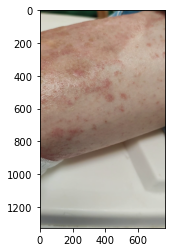

In [5]:



raw_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in raw_frames]
raw_frames=raw_frames[start_frame:(len(raw_frames)-end_frame)]
plt.imshow(raw_frames[3])
print(f'number of frames: {len(raw_frames)}')
print(f'frame shape: {raw_frames[4].shape[0]}:{raw_frames[4].shape[1]}')

Fs=30

N=len(raw_frames)
T=1/Fs
time=np.arange(0,N)/Fs
fouer_x=np.linspace(0.0, 1.0/(2.0*T), N//2)


In [36]:
y_start=180
y_end=700
x_start=10
x_end=750

normal_y_start=300
normal_y_end=600
normal_x_start=580
normal_x_end=750

psor_y_start=300
psor_y_end=500
psor_x_start=10
psor_x_end=200


green frames 3


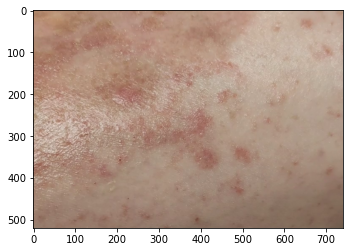

drawing normal frames 3


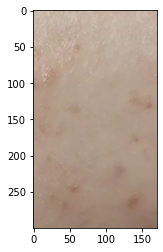

drawing psor frames 3


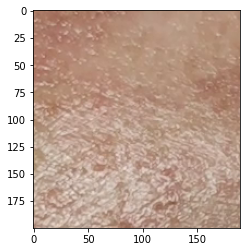

original image


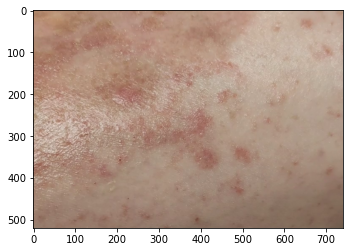

green frames 3


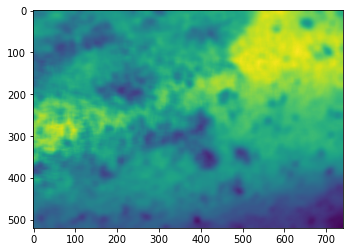

drawing normal frames 3


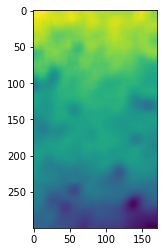

drawing psor frames 3


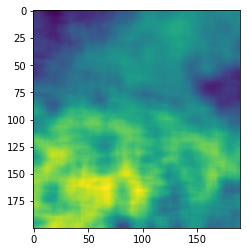

drawing hue frames 3


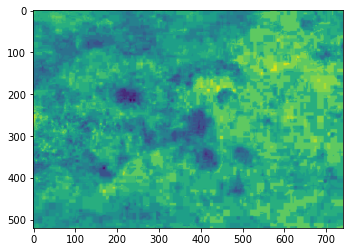

drawing normal hue frames 3


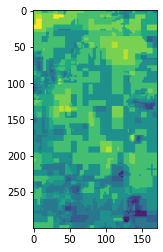

drawing psor hue frames 3


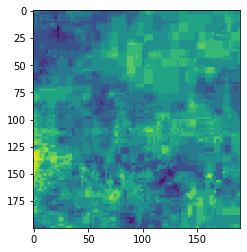

In [37]:


ROI_frames=[]
for frame in raw_frames:
    ROI=frame[y_start:y_end,x_start:x_end]
    ROI_frames.append(ROI)


normal_frames=[]
for frame in raw_frames:
    normal=frame[normal_y_start:normal_y_end,normal_x_start:normal_x_end]
    normal_frames.append(normal)
    
psor_frames=[]
for frame in raw_frames:
    psor=frame[psor_y_start:psor_y_end,psor_x_start:psor_x_end]
    psor_frames.append(psor)

print ('green frames 3')
plt.imshow(ROI_frames[3])
plt.show()
print ('drawing normal frames 3')
plt.imshow(normal_frames[3])
plt.show()

print ('drawing psor frames 3')
plt.imshow(psor_frames[3])
plt.show()

total_hsv=[cv2.cvtColor(frame, cv2.COLOR_RGB2HSV) for frame in ROI_frames]
normal_hsv=[cv2.cvtColor(frame, cv2.COLOR_RGB2HSV) for frame in normal_frames]
psor_hsv=[cv2.cvtColor(frame, cv2.COLOR_RGB2HSV) for frame in psor_frames]

hue=[frame[:,:,0] for frame in total_hsv]
normal_hue=[frame[:,:,0] for frame in normal_hsv]
psor_hue=[frame[:,:,0] for frame in psor_hsv]
    
green=[frame[:,:,1] for frame in ROI_frames]
normal_green=[frame[:,:,1] for frame in normal_frames]
psor_green=[frame[:,:,1] for frame in psor_frames]

    
if blur:
    frames=blur_frames(green,blur_kernel)
    normal_frames=blur_frames(normal_green,blur_kernel)
    psor_frames=blur_frames(psor_green,blur_kernel)
    hue_frames=blur_frames(hue,blur_kernel)
    hue_normal_frames=blur_frames(normal_hue,blur_kernel)
    hue_psor_frames=blur_frames(psor_hue,blur_kernel)
else:
    frames=green
    normal_frames=normal_green
    psor_frames=psor_green
    hue_frames=hue
    hue_normal_frames=normal_hue
    hue_psor_frames=psor_hue
    
print ('original image')
plt.imshow(ROI_frames[3])
plt.show()

    
print ('green frames 3')
plt.imshow(frames[3])
plt.show()
print ('drawing normal frames 3')
plt.imshow(normal_frames[3])
plt.show()

print ('drawing psor frames 3')
plt.imshow(psor_frames[3])
plt.show()

print ('drawing hue frames 3')
plt.imshow(hue[3])
plt.show()

print ('drawing normal hue frames 3')
plt.imshow(normal_hue[3])
plt.show()

print ('drawing psor hue frames 3')
plt.imshow(psor_hue[3])
plt.show()


## GET HEART BEAT

In [12]:
def rgb_mean(ROI,number_of_skin_pixels):
    r = np.sum(ROI[:, :, 2]) / number_of_skin_pixels
    g = np.sum(ROI[:, :, 1]) / number_of_skin_pixels
    b = np.sum(ROI[:, :, 0]) / number_of_skin_pixels

    return r,g,b

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def sig_detrend(sig, method, time):
    if method=="constant":
         return signal.detrend(sig,type="constant")
    elif method=="linear":
         return signal.detrend(sig,type="linear")
    elif method=="polymonial":
        lin = lambda x, a, b : a * x + b 
        coeff, _ = optimize.curve_fit(lin,time, sig)
        sig= sig-( coeff[0] * time + coeff[1])
        return sig
    else:
        return sig

def bandpass(sig, method,lowcut,highcut, Fs, order):
    if method=="butter":
        return butter_bandpass_filter(sig, lowcut, highcut, Fs, order=order)   
    
    else:
        return sig
    
    
def preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order):
    detrended_signal=sig_detrend(sig,detrend_method,time)
    bandpassed_signal=bandpass(detrended_signal, bandpass_method,lowcut,highcut, Fs, order)
    
    return bandpassed_signal

In [13]:
def get_pos_signal(rgb):
    window_size=46


    
    pos_signal = np.zeros(mean_rgb.shape[0])

    for window_start in range(0, (rgb.shape[0] - window_size)):
        window_mean_rgb = rgb[window_start:window_start + window_size - 1, :].T
        projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]])
        POS = np.matmul(projection_matrix, window_mean_rgb)
        std = np.array([1, np.std(POS[0, :]) / np.std(POS[1, :])])
        pulse = np.matmul(std, POS)
        pos_signal[window_start:window_start + window_size - 1] = pos_signal[
                                                                                window_start:window_start + window_size - 1] + (
                                                                                        pulse - np.mean(pulse)) / np.std(
                        pulse)
    return pos_signal

def get_heart_rate(sig, framerate, num_semgents=12):
    segment_length = (2 * sig.shape[0]) // (num_semgents + 1)
    sig = sig.flatten()
    green_f, green_psd = signal.welch(sig, framerate, 'flattop',
                                       nperseg=segment_length)  # , scaling='spectrum',nfft=2048)
    first = np.where(green_f > 0.9)[0]  # 0.8 for 300 frames
    last = np.where(green_f < 1.8)[0]
    first_index = first[0]
    last_index = last[-1]
    range_of_interest = range(first_index, last_index + 1, 1)
    max_idx = np.argmax(green_psd[range_of_interest])
    f_max = green_f[range_of_interest[max_idx]]

    hr = f_max * 60.0
    return hr

In [14]:
detrend_method="linear"
bandpass_method="butter"
lowcut = 0.5
highcut=4
order=5

In [15]:
mean_rgb = np.empty((0, 3))
for frame in ROI_frames:
    ROI=frame
    r,g,b=rgb_mean(ROI, ROI.shape[0]*ROI.shape[1])
    mean_rgb = np.append(mean_rgb, np.array([[r, g, b]]), axis=0)
    

for channel in range(mean_rgb.shape[1]):
    mean_rgb[:,channel]=preprocess_signal(mean_rgb[:,channel],detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )

    
pos=get_pos_signal(mean_rgb)

hr=get_heart_rate(pos,Fs)

print (f'heart rate: {hr}')

heart rate: 70.58823529411765


## GET EXAMPLE SIGNAL

In [16]:
def get_signal_from_frames(pixel_list, frames):
    signal=[]
    for frame in frames:
        signal.append(frame[pixel_list[0],pixel_list[1]])
    return np.array(signal)



In [17]:
example_pixel=[250,200]
detrend_method="linear"
bandpass_method="butter"
lowcut = 0.5
highcut=3
order=5

In [18]:
sig=get_signal_from_frames(example_pixel,hue_frames)
# sig=stats.zscore(sig)
proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )


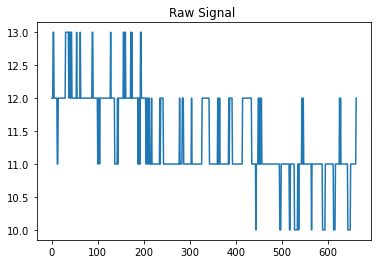

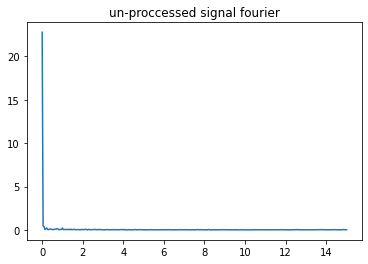

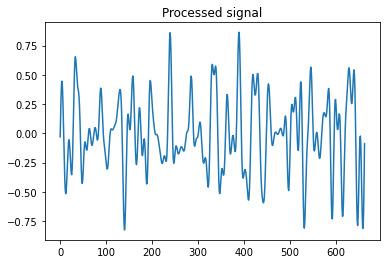

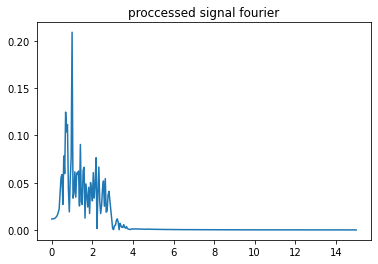

In [19]:
plt.plot(sig)
plt.title('Raw Signal ')

plt.show()

f=fft(sig)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('un-proccessed signal fourier')
plt.xlim()
plt.show()

proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
plt.plot(proc_sig)
# plt.title(f'{detrend_method} detrend {bandpass_method} bandpass' )
plt.title('Processed signal')
plt.show()

f=fft(proc_sig)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('proccessed signal fourier')
plt.xlim()
plt.show()

## AMPLITUDE MAP

In [21]:
def get_amplitude(heart_beat, sig):
    w = 5
    widths = w * 30 / (2 * heart_beat * np.pi)
    cwtm = signal.cwt(sig, signal.morlet2, [widths], w=w)
    heart_beat_amp=sum(np.abs(cwtm[0]))
    return heart_beat_amp

In [22]:
heart_rates=[60]
images={}
for hr in heart_rates:
    start = timeit.default_timer()

    image=np.zeros([frames[3].shape[0],frames[3].shape[1]])
    print (f'image size {image.shape}')
    print (f'estimated time: {22*(image.shape[0]*image.shape[1])/(700*1250)} minutes')
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            sig=get_signal_from_frames([x,y],hue_frames)
            sig=stats.zscore(sig)
            sig=np.nan_to_num(sig)
            proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
            amp=get_amplitude(hr/60,proc_sig)
            image[x,y]=amp
            if ((x%100==0)&(y%10000==0)):
                print (f'x is : {x}')
                stop = timeit.default_timer()

                print('Time: ', (stop - start)/60)  
    images[hr]=image
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)

image size (520, 740)
estimated time: 9.674971428571428 minutes
x is : 0
Time:  0.00012727500000030053
x is : 100
Time:  2.8829457916666668
x is : 200
Time:  5.819478118333334
x is : 300
Time:  8.457421745000001
x is : 400
Time:  11.573478848333334


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


x is : 500
Time:  14.534969041666667
Total Time:  903.9234313


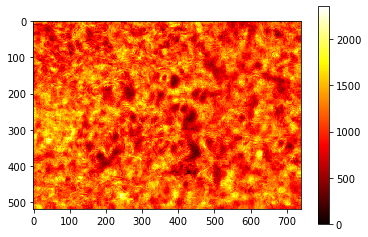

In [23]:
for image in images.keys():
    image=images[image]
    plt.imshow(image,cmap='hot', interpolation='nearest')
    plt.colorbar()

    plt.show()


NORMAL IMAGE

In [38]:
heart_rates=[60]
images={}
total_amp=0
for hr in heart_rates:
    start = timeit.default_timer()

    image=np.zeros([hue_normal_frames[3].shape[0],hue_normal_frames[3].shape[1]])
    print (f'image size {image.shape}')
    print (f'estimated time: {22*(image.shape[0]*image.shape[1])/(700*1250)} minutes')
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            sig=get_signal_from_frames([x,y],hue_normal_frames)
            sig=stats.zscore(sig)
            sig=np.nan_to_num(sig)
            proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
            amp=get_amplitude(hr/60,proc_sig)
            total_amp=total_amp+amp
            image[x,y]=amp
            if ((x%100==0)&(y%10000==0)):
                print (f'x is : {x}')
                stop = timeit.default_timer()

                print('Time: ', stop - start)  
    images[hr]=image
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)

print (total_amp)
print (f'num pixels: {(image.shape[0]*image.shape[1])}')
print (f'average amp pixels: {(total_amp/(image.shape[0]*image.shape[1]))}')


image size (300, 170)
estimated time: 1.2822857142857143 minutes
x is : 0
Time:  0.008003299999927549
x is : 100
Time:  35.38443059999986
x is : 200
Time:  66.2729683
Total Time:  97.58538090000002
56565178.60705781
num pixels: 51000
average amp pixels: 1109.1211491579963


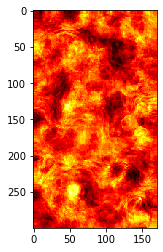

In [39]:
plt.imshow(image,cmap='hot', interpolation='nearest')

PSOR IMAGE

In [40]:
heart_rates=[60]
images={}
total_amp=0
for hr in heart_rates:
    start = timeit.default_timer()

    image=np.zeros([hue_psor_frames[3].shape[0],hue_psor_frames[3].shape[1]])
    print (f'image size {image.shape}')
    print (f'estimated time: {22*(image.shape[0]*image.shape[1])/(700*1250)} minutes')
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            sig=get_signal_from_frames([x,y],hue_psor_frames)
            sig=stats.zscore(sig)
            sig=np.nan_to_num(sig)
            proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
            amp=get_amplitude(hr/60,proc_sig)
            total_amp=total_amp+amp
            image[x,y]=amp
            if ((x%100==0)&(y%10000==0)):
                print (f'x is : {x}')
                stop = timeit.default_timer()

                print('Time: ', stop - start)  
    images[hr]=image
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)

print (total_amp)
print (f'num pixels: {(image.shape[0]*image.shape[1])}')
print (f'average amp pixels: {(total_amp/(image.shape[0]*image.shape[1]))}')


image size (200, 190)
estimated time: 0.9554285714285714 minutes
x is : 0
Time:  0.0060002000000167754
x is : 100
Time:  35.9580848999999
Total Time:  70.66333609999992
47782400.1461659
num pixels: 38000
average amp pixels: 1257.4315827938394


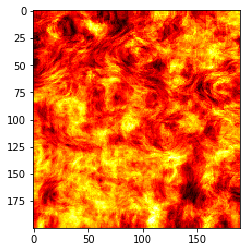

In [41]:
plt.imshow(image,cmap='hot', interpolation='nearest')

## SNR MAP

In [42]:
detrend_method="linear"
bandpass_method="butter"
lowcut = 0.5
highcut=6
order=5

In [43]:
def get_snr(sig,fouer_x,hr,bin_size, max_freq, min_freq):
    
    f=fft(sig)
    fourier=2.0/N * np.abs(f[0:N//2])
    Fheart_index=np.abs(np.array(fouer_x) - hr/60).argmin()

    signal_bins=list(range(Fheart_index-bin_size, Fheart_index+bin_size+1)) + list(range(Fheart_index*2-bin_size, Fheart_index*2+bin_size+1))

    max_bin=np.where(fouer_x >= max_freq)[0][0]
    min_bin=np.where(fouer_x <= min_freq)[0][-1]


    noise_bins=np.arange(min_bin,max_bin)
    noise_bins=noise_bins[~np.isin(noise_bins,signal_bins)]
    noise_values=fourier[noise_bins]
    noise_values=[val**2 for val in noise_values]


    signal_values=fourier[signal_bins]
    signal_values=[val**2 for val in signal_values]
    if sum(noise_values)==0:
        snr=-7.5
    
    else:
        snr=10*math.log10(sum(signal_values)/sum(noise_values))

    return snr

In [44]:
snr_dict={'hr':[55],
          'bins':[1,2],
         'max_freq':[4]}
allNames = (snr_dict)
combinations = it.product(*(snr_dict[Name] for Name in allNames))
combinations=(list(combinations))


images={}
for combi in combinations:
    hr=combi[0]
    bin_size=combi[1]
    max_freq=combi[2]
    image_name=f'{hr}_{bin_size}_{max_freq}'
    
    start = timeit.default_timer()

    image=np.zeros([frames[3].shape[0],frames[3].shape[1]])
    print (f'image size {image.shape}')
    print (f'estimated time: {22*(image.shape[0]*image.shape[1])/(700*1250)} minutes')
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            sig=get_signal_from_frames([x,y],hue_frames)
            sig=stats.zscore(sig)
            sig=np.nan_to_num(sig)

            proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
            snr=get_snr(proc_sig, fouer_x,hr,bin_size,max_freq,0.5)
            image[x,y]=snr
            if ((x%100==0)&(y%10000==0)):
                print (f'x is : {x}')
                stop = timeit.default_timer()

                print('Time: ', stop - start) 
    images[image_name]=image
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)

image size (520, 740)
estimated time: 9.674971428571428 minutes
x is : 0
Time:  0.011795599999913975
x is : 100
Time:  147.63776989999997
x is : 200
Time:  286.31518510000024
x is : 300
Time:  412.60816380000006
x is : 400
Time:  539.7834662
x is : 500
Time:  666.0941908
Total Time:  690.9015391000003
image size (520, 740)
estimated time: 9.674971428571428 minutes
x is : 0
Time:  0.0024799999996503175
x is : 100
Time:  127.4844450999999
x is : 200
Time:  254.46799190000002
x is : 300
Time:  382.42587669999966
x is : 400
Time:  509.5621845999999
x is : 500
Time:  637.2449108999999
Total Time:  662.6242193999997


55_1_4


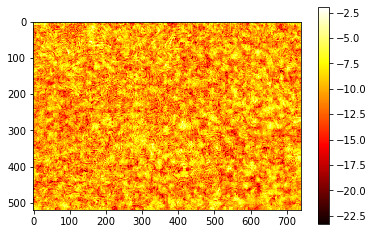

55_2_4


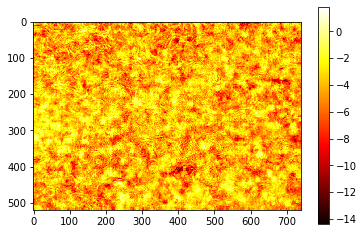

In [45]:
for image_name in images.keys():
    print(image_name)
    image=images[image_name]    
  
    plt.imshow(image,cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()


SNR NORMAL IMAGE

In [46]:
snr_dict={'hr':[60],
          'bins':[2],
         'max_freq':[4]}
allNames = (snr_dict)
combinations = it.product(*(snr_dict[Name] for Name in allNames))
combinations=(list(combinations))


images={}

for combi in combinations:
    snr_total=0
    hr=combi[0]
    bin_size=combi[1]
    max_freq=combi[2]
    image_name=f'{hr}_{bin_size}_{max_freq}'
    
    start = timeit.default_timer()
    
    image=np.zeros([hue_normal_frames[3].shape[0],hue_normal_frames[3].shape[1]])
    print (f'image size {image.shape}')
    print (f'estimated time: {22*(image.shape[0]*image.shape[1])/(700*1250)} minutes')
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            sig=get_signal_from_frames([x,y],hue_normal_frames)
            sig=stats.zscore(sig)
            sig=np.nan_to_num(sig)

            proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
            try:
                snr=get_snr(proc_sig, fouer_x,hr,bin_size,max_freq,0.5)
            except:
                snr=snr
            snr_total=snr_total+snr
            image[x,y]=snr
            if ((x%100==0)&(y%10000==0)):
                print (f'x is : {x}')
                stop = timeit.default_timer()

                print('Time: ', stop - start) 
    images[image_name]=image
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)
    print (snr_total)
    print (f'num pixels: {(image.shape[0]*image.shape[1])}')
    print (f'average amp pixels: {(snr_total/(image.shape[0]*image.shape[1]))}') 

image size (300, 170)
estimated time: 1.2822857142857143 minutes
x is : 0
Time:  0.005372999999963213
x is : 100
Time:  29.38840089999985
x is : 200
Time:  58.05578409999998
Total Time:  87.35551870000018
-215513.9222996196
num pixels: 51000
average amp pixels: -4.225763182345482


60_2_4


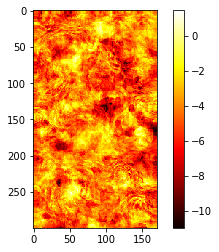

In [47]:
for image_name in images.keys():
    print(image_name)
    image=images[image_name]    
  
    plt.imshow(image,cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()


PSOR SNR

In [48]:
snr_dict={'hr':[60],
          'bins':[2],
         'max_freq':[4]}
allNames = (snr_dict)
combinations = it.product(*(snr_dict[Name] for Name in allNames))
combinations=(list(combinations))


images={}

for combi in combinations:
    snr_total=0
    hr=combi[0]
    bin_size=combi[1]
    max_freq=combi[2]
    image_name=f'{hr}_{bin_size}_{max_freq}'
    
    start = timeit.default_timer()
    
    image=np.zeros([hue_psor_frames[3].shape[0],hue_psor_frames[3].shape[1]])
    print (f'image size {image.shape}')
    print (f'estimated time: {22*(image.shape[0]*image.shape[1])/(700*1250)} minutes')
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            sig=get_signal_from_frames([x,y],hue_psor_frames)
            sig=stats.zscore(sig)
            sig=np.nan_to_num(sig)

            proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
            snr=get_snr(proc_sig, fouer_x,hr,bin_size,max_freq,0.5)
            if np.isnan(snr):
                pass
            else:
                snr_total=snr_total+snr
            image[x,y]=snr
            if ((x%100==0)&(y%10000==0)):
                print (f'x is : {x}')
                stop = timeit.default_timer()

                print('Time: ', stop - start) 
    images[image_name]=image
    stop = timeit.default_timer()
    print('Total Time: ', stop - start)
    print (snr_total)
    print (f'num pixels: {(image.shape[0]*image.shape[1])}')
    print (f'average amp pixels: {(snr_total/(image.shape[0]*image.shape[1]))}') 

image size (200, 190)
estimated time: 0.9554285714285714 minutes
x is : 0
Time:  0.0040582999999969616
x is : 100
Time:  32.308352600000035
Total Time:  64.26466759999994
-137656.39960813176
num pixels: 38000
average amp pixels: -3.622536831792941


60_2_4


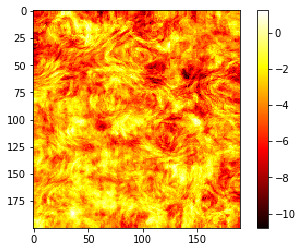

In [49]:
for image_name in images.keys():
    print(image_name)
    image=images[image_name]    
  
    plt.imshow(image,cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()


## REFERNCE

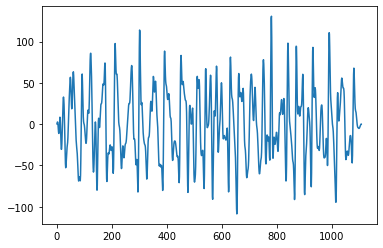

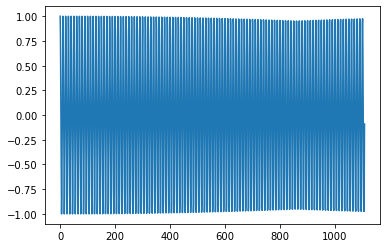

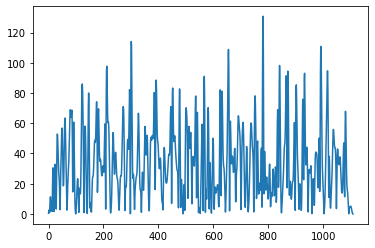

In [283]:
length=N/Fs
n=np.arange(0,length,1/Fs)
y=np.exp(2*1j*np.pi*3*n)

plt.plot(pos)
plt.show()

plt.plot(y.real)
plt.show()

mul=np.multiply(y,pos)
plt.plot(np.abs(mul))
plt.show()

In [284]:
ref_frames=[]
for i,frame in enumerate(frames):
    new_frame=frame*y[i]
    ref_frames.append(new_frame)

In [269]:
sig=get_signal_from_frames([200,200],ref_frames)

In [285]:
image=np.zeros([frames[3].shape[0],frames[3].shape[1]])
for x in range(image.shape[0]):
    for y in range(image.shape[1]):
        sig=get_signal_from_frames([x,y],frames)
        sum_sig=sum(sig)
        image[x,y]=np.abs(sum_sig)
        if ((x%100==0)&(y%400==0)):
            print (f'{x} and {y}')

0 and 0
0 and 400
100 and 0
100 and 400
200 and 0
200 and 400
300 and 0
300 and 400
400 and 0
400 and 400


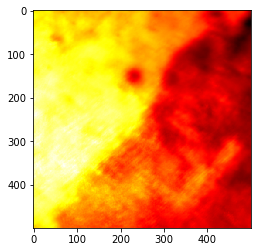

In [286]:
plt.imshow(image,cmap='hot', interpolation='nearest')

In [289]:
image2=np.zeros([frames[3].shape[0],frames[3].shape[1]])
for x in range(image.shape[0]):
    for y in range(image.shape[1]):
        sig=get_signal_from_frames([x,y],frames)
        sum_sig=sum(np.abs(sig))
        image2[x,y]=sum_sig
        if ((x%100==0)&(y%400==0)):
            print (f'{x} and {y}')

0 and 0
0 and 400
100 and 0
100 and 400
200 and 0
200 and 400
300 and 0
300 and 400
400 and 0
400 and 400


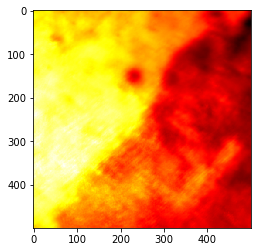

In [290]:
plt.imshow(image2,cmap='hot', interpolation='nearest')